# XGBoost

## Import libraries

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import datetime as dt
import xgboost as xgb
import seaborn as sns
import pandas as pd
import numpy as np
import pickle


# Sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing

# Matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

# Files
from util import fetchOnlineData, create_dataset
from indicators import get_indicators

# TA Library (https://github.com/bukosabino/ta)
from ta import *

sns.set(font_scale = 1.5)

## Initial variables

In [2]:
symbol = "AABA"

# We'll look back 365 days
start_d = dt.date.today() - dt.timedelta(365)

# Compute indicators from TA library

## Import dataset

In [3]:
yesterday = dt.date.today() - dt.timedelta(1)
portf_value = fetchOnlineData(start_d, symbol, yesterday, del_cols=False)

[*********************100%***********************]  1 of 1 downloaded


In [4]:
df = add_all_ta_features(portf_value, "Open", "High", "Low", "Close", "Volume", fillna=True)

/home/emi/PycharmProjects/factors/lib/python3.7/site-packages/ta/trend.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/home/emi/PycharmProjects/factors/lib/python3.7/site-packages/ta/trend.py:174: RuntimeWarning:

invalid value encountered in double_scalars

/home/emi/PycharmProjects/factors/lib/python3.7/site-packages/ta/trend.py:634: FutureWarning:

Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning

/home/emi/PycharmProjects/factors/lib/python3.7/site-packages/ta/trend.py:656: FutureWarning:

Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning



In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 253 entries, 2018-04-16 to 2019-04-16
Data columns (total 65 columns):
Open                       253 non-null float64
High                       253 non-null float64
Low                        253 non-null float64
Close                      253 non-null float64
Adj Close                  253 non-null float64
Volume                     253 non-null int64
volume_adi                 253 non-null float64
volume_obv                 253 non-null int64
volume_obvm                253 non-null float64
volume_cmf                 253 non-null float64
volume_fi                  253 non-null float64
volume_em                  253 non-null float64
volume_vpt                 253 non-null float64
volume_nvi                 253 non-null float64
volatility_atr             253 non-null float64
volatility_bbh             253 non-null float64
volatility_bbl             253 non-null float64
volatility_bbm             253 non-null float64
volatility_bbhi 

## Changing index and columns

In [6]:
# Delete unuseful columns
del df['Open']
del df['High']
del df['Low']
del df['Close']
del df['Volume']


# Create 'date' column for posterior index
df['date'] = df.index

# Rename column for correlation matrix. Can't have spaces.
df.rename(columns={'Adj Close': 'Adj_Close'}, inplace=True)

# Reset index
df.reset_index(inplace=True)

## Correlation matrix

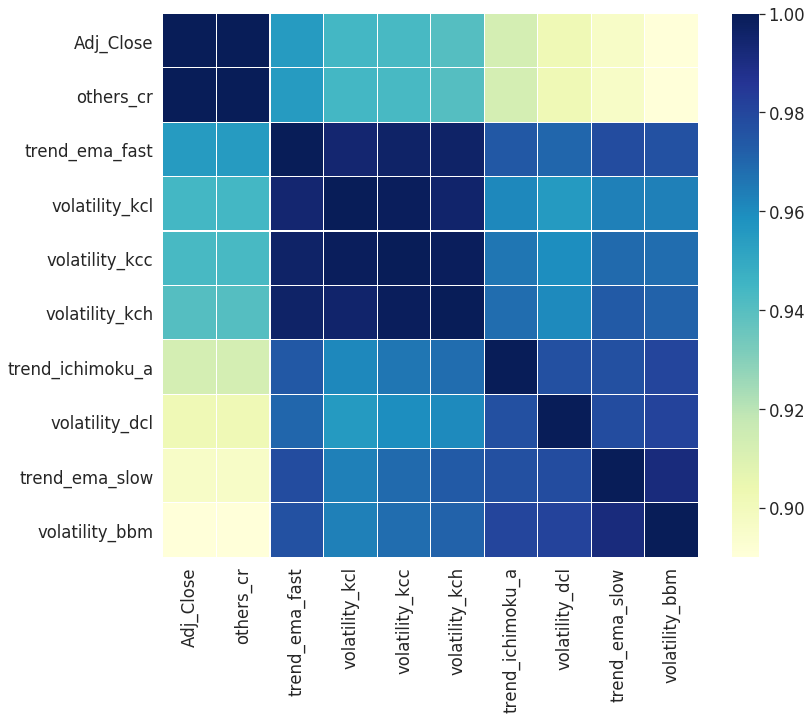

In [7]:
# Adj Close correlation matrix
corrmat = df.corr()
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'Adj_Close')['Adj_Close'].index
cm = np.corrcoef(df[cols].values.T)
f, ax = plt.subplots(figsize =(12, 10)) 
sns.heatmap(cm, ax = ax, cmap ="YlGnBu", 
            linewidths = 0.1, yticklabels = cols.values,  
                              xticklabels = cols.values) 
plt.show()

## Indicators to use

* others_cr: Cumulative Return.
* trend_ema_fast: Fast Exponential Moving Averages (EMA) 
* volatility_kcl: Keltner Channel

### Create a dataframe with indicators to use

In [8]:
dataset = df[['Adj_Close', 'others_cr', 'trend_ema_fast', 'volatility_kcl']].copy()

## Scale data for using reg:logistic
If we want use objective = reg: if we want use objective = reg:logistic logistic regression, the label needed to be pre-scaled into [0,1]. logistic regression, the label needed to be pre-scaled into [0,1].

In [9]:
# Scale the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
np_scaled = scaler.fit_transform(dataset)
dataset_normalized = pd.DataFrame(np_scaled)

## Setup the Target variable or the desired output.

In [10]:
X, y = dataset_normalized.iloc[:,:-1], dataset_normalized.iloc[:,-1]

## Create XGBoost DMatrix structure

In [11]:
feature_names = ['others_cr', 'trend_ema_fast', 'volatility_kcl']
data_dmatrix = xgb.DMatrix(data=X,label=y, feature_names=feature_names)

/home/emi/PycharmProjects/factors/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

/home/emi/PycharmProjects/factors/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



## Optimize parameters

In [12]:
print("Parameter optimization")

xgb_model = xgb.XGBRegressor()
clf = GridSearchCV(xgb_model,
                   {'max_depth': [2,4,6],
                    'n_estimators': [50,100,200],
                    'learning_rate': [0.01, 0.1, 0.5],
                    'min_samples_split':range(200,1001,2000)}, verbose=1)
clf.fit(X,y)
print('Best Score: ', clf.best_score_)
print('Best params: ', clf.best_params_)

Parameter optimization
Fitting 3 folds for each of 27 candidates, totalling 81 fits


/home/emi/PycharmProjects/factors/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning:

You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/home/emi/PycharmProjects/factors/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

/home/emi/PycharmProjects/factors/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

/home/emi/PycharmProjects/factors/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

/home/emi/PycharmProjects/factors/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



Best Score:  0.7696322365473437
Best params:  {'learning_rate': 0.5, 'max_depth': 6, 'min_samples_split': 200, 'n_estimators': 100}


## Create a hyper-parameter dictionary

We will create a hyper-parameter dictionary params which holds all the hyper-parameters and their values as key-value pairs but will exclude the n_estimators from the hyper-parameter dictionary because you will use num_boost_rounds instead.

In [13]:
params = {'silent':1,
          "objective":"reg:logistic",
          'colsample_bytree': 0.3,
          'learning_rate': 0.5,
          'max_depth': 2,
          'alpha': 10,
          'min_samples_split': 200,
          'n_estimators': 200}

We will use these parameters to build a x-fold cross validation model by invoking XGBoost's cv() method and store the results in a cv_results DataFrame. Note that here you are using the Dmatrix object you created before.

In [14]:
cv_results = xgb.cv(verbose_eval=False,
                    dtrain=data_dmatrix, 
                    params=params, 
                    nfold=10,
                    num_boost_round=50,
                    early_stopping_rounds=10,
                    metrics="rmse", 
                    as_pandas=True, 
                    seed=123,)

## cv_results contains train and test RMSE metrics for each boosting round.

In [15]:
cv_results.head()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,0.200599,0.002017,0.200075,0.024920
1,0.172803,0.003644,0.173063,0.024556
2,0.159060,0.003608,0.159327,0.025683
3,0.151166,0.003556,0.151631,0.026595
4,0.145499,0.002760,0.145914,0.026584


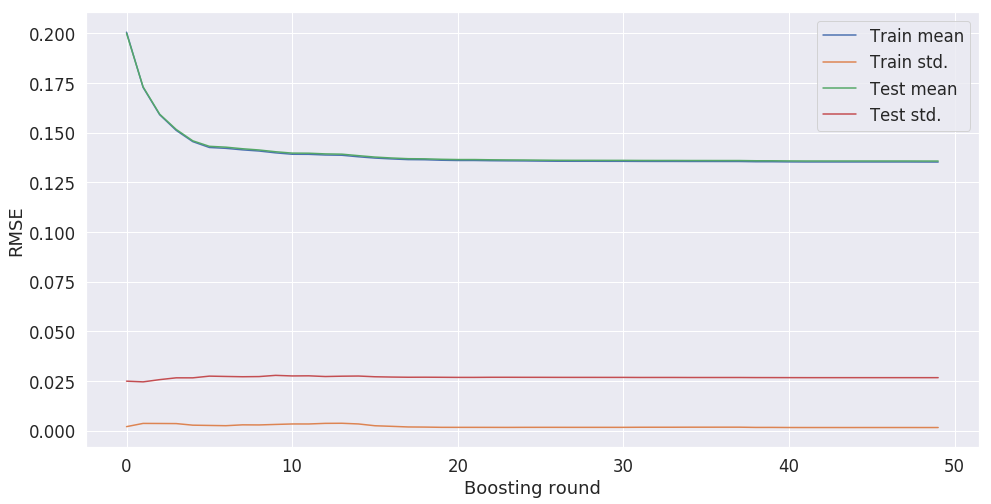

In [16]:
plt.figure(figsize=(16,8))
plt.plot(cv_results)
plt.xlabel('Boosting round')
plt.ylabel("RMSE")
plt.legend(["Train mean", "Train std.", "Test mean", "Test std."])
plt.show()

## Extract and print the final boosting round metric.

In [17]:
print((cv_results["test-rmse-mean"]).tail(1))

49    0.135725
Name: test-rmse-mean, dtype: float64


You can see that your RMSE for the price prediction has reduced as compared to last time and came out to be lower. 

You can reach an even lower RMSE for a different set of hyper-parameters. You may consider applying techniques like Grid Search, Random Search and Bayesian Optimization to reach the optimal set of hyper-parameters. 

## Instantiate an XGBoost regressor object

In [18]:
xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=10)

## Plotting the first tree

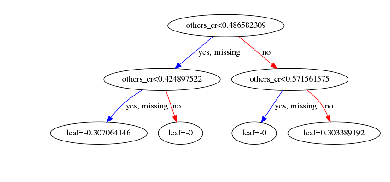

In [19]:
xgb.plot_tree(xg_reg,num_trees=0)
plt.rcParams['figure.figsize'] = [140, 120]
plt.show()

## Visualize your XGBoost models

It's to examine the importance of each feature column in the original dataset within the model.

In [20]:
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [8, 6]
plt.show()

## Instantiate an XGBoost regressor object

## Split the data

In [21]:
# Define X and y
feature_cols = ['others_cr', 'trend_ema_fast', 'volatility_kcl']
X = dataset[feature_cols]
y = dataset['Adj_Close']

In [22]:
# split X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, shuffle=False)

## Scale data for using reg:logistic
If we want use objective = reg: if we want use objective = reg:logistic logistic regression, the label needed to be pre-scaled into [0,1]. logistic regression, the label needed to be pre-scaled into [0,1].

In [23]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

y_train_scaled = scaler.fit_transform(np.array(y_train).reshape(-1, 1))
y_test_scaled = scaler.fit_transform(np.array(y_test).reshape(-1, 1))

In [24]:
xg_reg = xgb.XGBRegressor(**params)

## Fit the regressor to the training set

In [25]:
xg_reg.fit(X_train_scaled,y_train_scaled, eval_set=[(X_train_scaled, y_train_scaled), (X_test_scaled, y_test_scaled)],)

[0]	validation_0-rmse:0.14888	validation_1-rmse:0.191463
[1]	validation_0-rmse:0.097033	validation_1-rmse:0.121607
[2]	validation_0-rmse:0.066817	validation_1-rmse:0.078603
[3]	validation_0-rmse:0.048262	validation_1-rmse:0.053737
[4]	validation_0-rmse:0.039755	validation_1-rmse:0.042485
[5]	validation_0-rmse:0.032491	validation_1-rmse:0.036873
[6]	validation_0-rmse:0.030035	validation_1-rmse:0.036556
[7]	validation_0-rmse:0.029131	validation_1-rmse:0.037919
[8]	validation_0-rmse:0.028759	validation_1-rmse:0.039974
[9]	validation_0-rmse:0.027993	validation_1-rmse:0.041652
[10]	validation_0-rmse:0.026234	validation_1-rmse:0.040528
[11]	validation_0-rmse:0.025287	validation_1-rmse:0.040168
[12]	validation_0-rmse:0.024693	validation_1-rmse:0.041392
[13]	validation_0-rmse:0.024342	validation_1-rmse:0.04135
[14]	validation_0-rmse:0.024083	validation_1-rmse:0.041586
[15]	validation_0-rmse:0.023925	validation_1-rmse:0.041818
[16]	validation_0-rmse:0.023572	validation_1-rmse:0.0414
[17]	valida

XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.3, gamma=0, importance_type='gain',
       learning_rate=0.5, max_delta_step=0, max_depth=2,
       min_child_weight=1, min_samples_split=200, missing=None,
       n_estimators=200, n_jobs=1, nthread=None, objective='reg:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=1, subsample=1)

## Make predictions on the test set

In [26]:
preds = xg_reg.predict(X_test_scaled)

In [27]:
preds

array([0.05445538, 0.04437907, 0.07423145, 0.07423145, 0.07423145,
       0.10053089, 0.16585547, 0.20027676, 0.26727283, 0.37049484,
       0.3780728 , 0.32432574, 0.35761282, 0.36817476, 0.41173425,
       0.40052038, 0.3506269 , 0.3506269 , 0.3733612 , 0.43578154,
       0.43578154, 0.3982956 , 0.5687109 , 0.58985907, 0.5887097 ,
       0.5887097 , 0.6992871 , 0.6441328 , 0.5945512 , 0.6023091 ,
       0.6023091 , 0.6386039 , 0.62963533, 0.59621155, 0.57861006,
       0.62963533, 0.6457111 , 0.6457111 , 0.7673224 , 0.89845985,
       0.9075107 , 0.91917026, 0.91500884, 0.90750676, 0.92598754,
       0.93320763, 0.9403034 , 0.8571919 , 0.8076594 , 0.91817486,
       0.91817486, 0.9267423 , 0.9267423 , 0.9267423 , 0.9267423 ,
       0.9267423 , 0.9267423 , 0.9267423 , 0.8271992 , 0.8635102 ,
       0.8418784 , 0.8356186 , 0.8418784 , 0.91817486, 0.9267423 ,
       0.9267423 , 0.8635102 , 0.8660489 , 0.9267423 , 0.934377  ,
       0.9403034 , 0.9403034 , 0.9403034 , 0.9403034 , 0.92981

## Compute the rmse

In [28]:
rmse = np.sqrt(mean_squared_error(y_test_scaled, preds))
print("RMSE: %f" % (rmse))

RMSE: 0.040892


## Plotting

### Standarize data 

In [29]:
preds = scaler.inverse_transform([preds])


In [30]:
# Convert array to series
mylist = preds.tolist()
se = pd.Series(mylist)


In [31]:
# Create a dataframe for plotting
predictions = pd.DataFrame()
predictions['Price'] = y_test
predictions['Forecast'] = se[0]

# Create dates df index
df1 = df['date'].tail(len(y_test))

# Concatenate both dataframes
pred = pd.concat([predictions, df1], axis=1)

# Set index
pred.set_index('date', inplace=True)


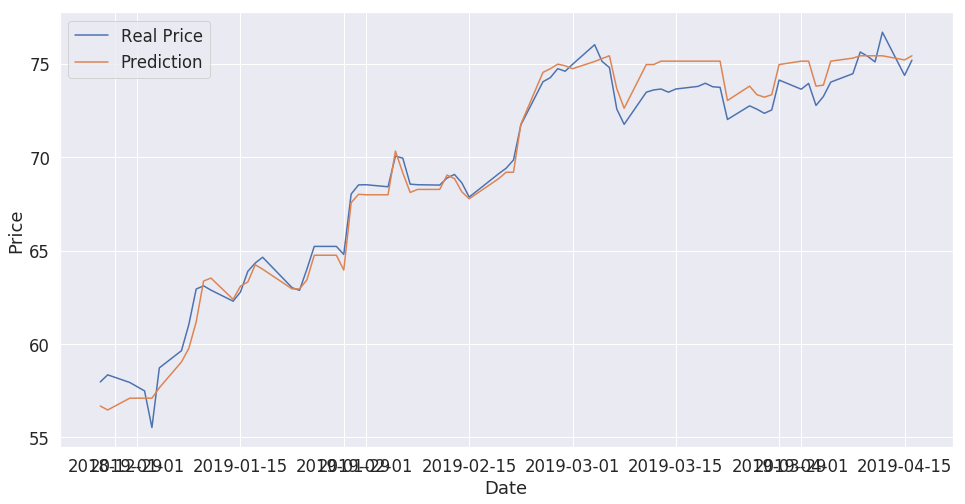

In [32]:
plt.figure(figsize=(16,8))
plt.plot(pred)
plt.xlabel('Date')
plt.ylabel("Price")
plt.legend(["Real Price", "Prediction"])
plt.show()

# Save model

In [33]:
# save model to file
#joblib.dump(model, "./xgboost.dat")
# The sklearn API models are picklable
print("Pickling sklearn API models")
# must open in binary format to pickle
pickle.dump(xg_reg, open("./xgboost.pkl", "wb"))

Pickling sklearn API models


## #############################

In [34]:
yesterday = dt.date.today() - dt.timedelta(1)
portf_value = fetchOnlineData(start_d, symbol, yesterday, del_cols=False)

[*********************100%***********************]  1 of 1 downloaded


In [35]:
# load model
model = pickle.load(open("./xgboost.pkl", "rb"))


forecast_lookback = 365

# Lookback data

lookback_date = dt.date.today() - dt.timedelta(forecast_lookback)
dates = pd.date_range(lookback_date, periods=forecast_lookback)
#df_prices = slice_df(portf_value, dates)
df_prices = portf_value[['Adj Close']].copy()

In [36]:
###############################
# Create datafrane with all TA indicators
df = add_all_ta_features(portf_value, "Open", "High", "Low", "Close", "Volume", fillna=True)

/home/emi/PycharmProjects/factors/lib/python3.7/site-packages/ta/trend.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/home/emi/PycharmProjects/factors/lib/python3.7/site-packages/ta/trend.py:174: RuntimeWarning:

invalid value encountered in double_scalars

/home/emi/PycharmProjects/factors/lib/python3.7/site-packages/ta/trend.py:634: FutureWarning:

Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning

/home/emi/PycharmProjects/factors/lib/python3.7/site-packages/ta/trend.py:656: FutureWarning:

Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning



In [37]:
# Delete unuseful columns
del df['Open']
del df['High']
del df['Low']
del df['Close']
del df['Volume']

In [38]:
# Create 'date' column for posterior index
df['date'] = df.index

# Rename column for correlation matrix. Can't have spaces.
df.rename(columns={'Adj Close': 'Adj_Close'}, inplace=True)

# Reset index
df.reset_index(inplace=True)

## Indicators to use
'''
    * others_cr: Cumulative Return. (Close)
    * trend_ema_fast: Fast Exponential Moving Averages(EMA) (Close)
    * volatility_kcl: Keltner channel (KC) (High, Low, Close)'''

'\n    * others_cr: Cumulative Return. (Close)\n    * trend_ema_fast: Fast Exponential Moving Averages(EMA) (Close)\n    * volatility_kcl: Keltner channel (KC) (High, Low, Close)'

In [39]:
# Scale data for using reg:logistic as array
scaler = MinMaxScaler(feature_range=(0, 1))
features = df[['others_cr', 'trend_ema_fast', 'volatility_kcl']]
dataset_scaled = scaler.fit_transform(features)

In [40]:
# Scale X_test (Adj_Close)
scaler1 = MinMaxScaler(feature_range=(0, 1))
feature = df[['Adj_Close']]
X_test_scaled = scaler1.fit_transform(feature)

In [41]:
###############################

# Next Bussines days
start = dt.date.today().strftime("%Y-%m-%d")
rng = pd.date_range(pd.Timestamp(start), periods=1, freq='B')
bussines_days = rng.strftime('%Y-%m-%d')

# Setting prediction dataframe cols and list for saving predictions
cols = ['Price', 'date']
lst = []

In [42]:
# Calculate price
prediction = model.predict(dataset_scaled)

In [43]:
# TODO Standarize data
preds = scaler1.inverse_transform(prediction.reshape(-1,1))

In [44]:
# Convert array to series
mylist = preds.tolist()
p = mylist[-1][-1]
p

74.76937866210938

In [45]:
# Adding value to predictions dataframe for plotting
lst.append([p, bussines_days.values[0]])
df_predictions = pd.DataFrame(lst, columns=cols)

In [46]:
df_predictions

,Price,date
0,74.769379,2019-04-17
